In [1]:
import os

# Choose which GPU(s) are visible to PyTorch
# For example, use only GPU 0:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [9]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("facebook/natural_reasoning", split="train")

# View one sample
sample = dataset[1]

# Extract the response text (nested inside the "responses" list)
response_text = sample["responses"][0]["response"]

print(sample["reference_answer"])


A well-structured proposal addressing the challenges and implications of constructing a system without infinity, including discussions on set theory, analysis, and potential applications.


In [5]:
from typing import List

def split_cot_flexible(
    texts: List[str],
    min_chars: int = 300,
    merge_threshold: int = 80,
) -> List[List[str]]:
    """
    Splits text into paragraphs (based on blank lines) and merges short ones
    with the next paragraph if they're below `merge_threshold` characters.

    - No regex
    - Never drops content
    - Preserves full paragraphs
    - Works on essays, CoT reasoning, or markdown-style text
    """

    all_docs: List[List[str]] = []

    for text in texts:
        if not isinstance(text, str) or not text.strip():
            all_docs.append([])
            continue

        # Split into paragraphs
        paragraphs = [p.strip() for p in text.split("\n\n") if p.strip()]
        merged: List[str] = []
        i = 0

        while i < len(paragraphs):
            current = paragraphs[i]

            # Merge this paragraph with the next if it's short
            if len(current) < merge_threshold and i + 1 < len(paragraphs):
                current = current + "\n\n" + paragraphs[i + 1]
                i += 2
            else:
                i += 1

            merged.append(current.strip())

        # Optionally merge tiny sections into larger ones (< min_chars total)
        final: List[str] = []
        buffer = ""
        for j, para in enumerate(merged):
            if len(buffer) + len(para) < min_chars and j < len(merged) - 1:
                buffer += ("\n\n" if buffer else "") + para
            else:
                if buffer:
                    final.append(buffer.strip())
                    buffer = ""
                final.append(para.strip())
        if buffer:
            final.append(buffer.strip())

        all_docs.append(final)

    return all_docs


In [6]:
foo = split_cot_flexible([response_text])

In [8]:
foo[0][1]

'**Construction of Practical Numbers**\n\nThe system of Practical Numbers, **P**, is constructed as follows:'

In [6]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

model_name = "Qwen/Qwen3-0.6B"

# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype="auto",
    device_map="auto"
)

# Suppose these are your "thoughts"
thoughts = foo[0]

# Tokenize each thought individually
tokenized_thoughts = []
for i, thought in enumerate(thoughts, 1):
    messages = [{"role": "user", "content": thought}]
    text = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=False,
        enable_thinking=True
    )
    tokens = tokenizer(text, return_tensors="pt").to(model.device)
    tokenized_thoughts.append(tokens)
    print(f"\n--- Thought {i} ---")
    print(f"Raw text:\n{thought}\n")
    print(f"Token IDs: {tokens['input_ids'][0].tolist()}")
    print(f"Token count: {tokens['input_ids'].shape[-1]}")

# If you want to feed them to the model (optional)
with torch.no_grad():
    outputs = [model(**t) for t in tokenized_thoughts]


`torch_dtype` is deprecated! Use `dtype` instead!



--- Thought 1 ---
Raw text:
**Introduction to Practical Numbers**

The system of Practical Numbers is a proposed mathematical framework that rejects the Axiom of Choice and the concept of infinity. This system is designed to provide a more concrete and constructive approach to mathematics, focusing on finite and computable operations. In this system, we will introduce a new number system, which we will denote as **P**.

Token IDs: [151644, 872, 198, 334, 37155, 311, 65636, 34713, 56177, 785, 1849, 315, 65636, 34713, 374, 264, 10981, 35972, 12626, 429, 59415, 279, 362, 11665, 316, 315, 27107, 323, 279, 7286, 315, 54910, 13, 1096, 1849, 374, 6188, 311, 3410, 264, 803, 14175, 323, 53484, 5486, 311, 37596, 11, 21080, 389, 34226, 323, 3716, 480, 7525, 13, 758, 419, 1849, 11, 582, 686, 19131, 264, 501, 1372, 1849, 11, 892, 582, 686, 78064, 438, 3070, 47, 334, 13, 151645, 198]
Token count: 79

--- Thought 2 ---
Raw text:
**Construction of Practical Numbers**

The system of Practical Numbers,


Analyzing thought with 70 tokens in 1024-dimensional space...


/tmp/ipykernel_3225093/576455005.py:126: RuntimeWarning: invalid value encountered in log1p
  im3 = ax3.imshow(np.log1p(G_np), cmap='plasma', aspect='auto')


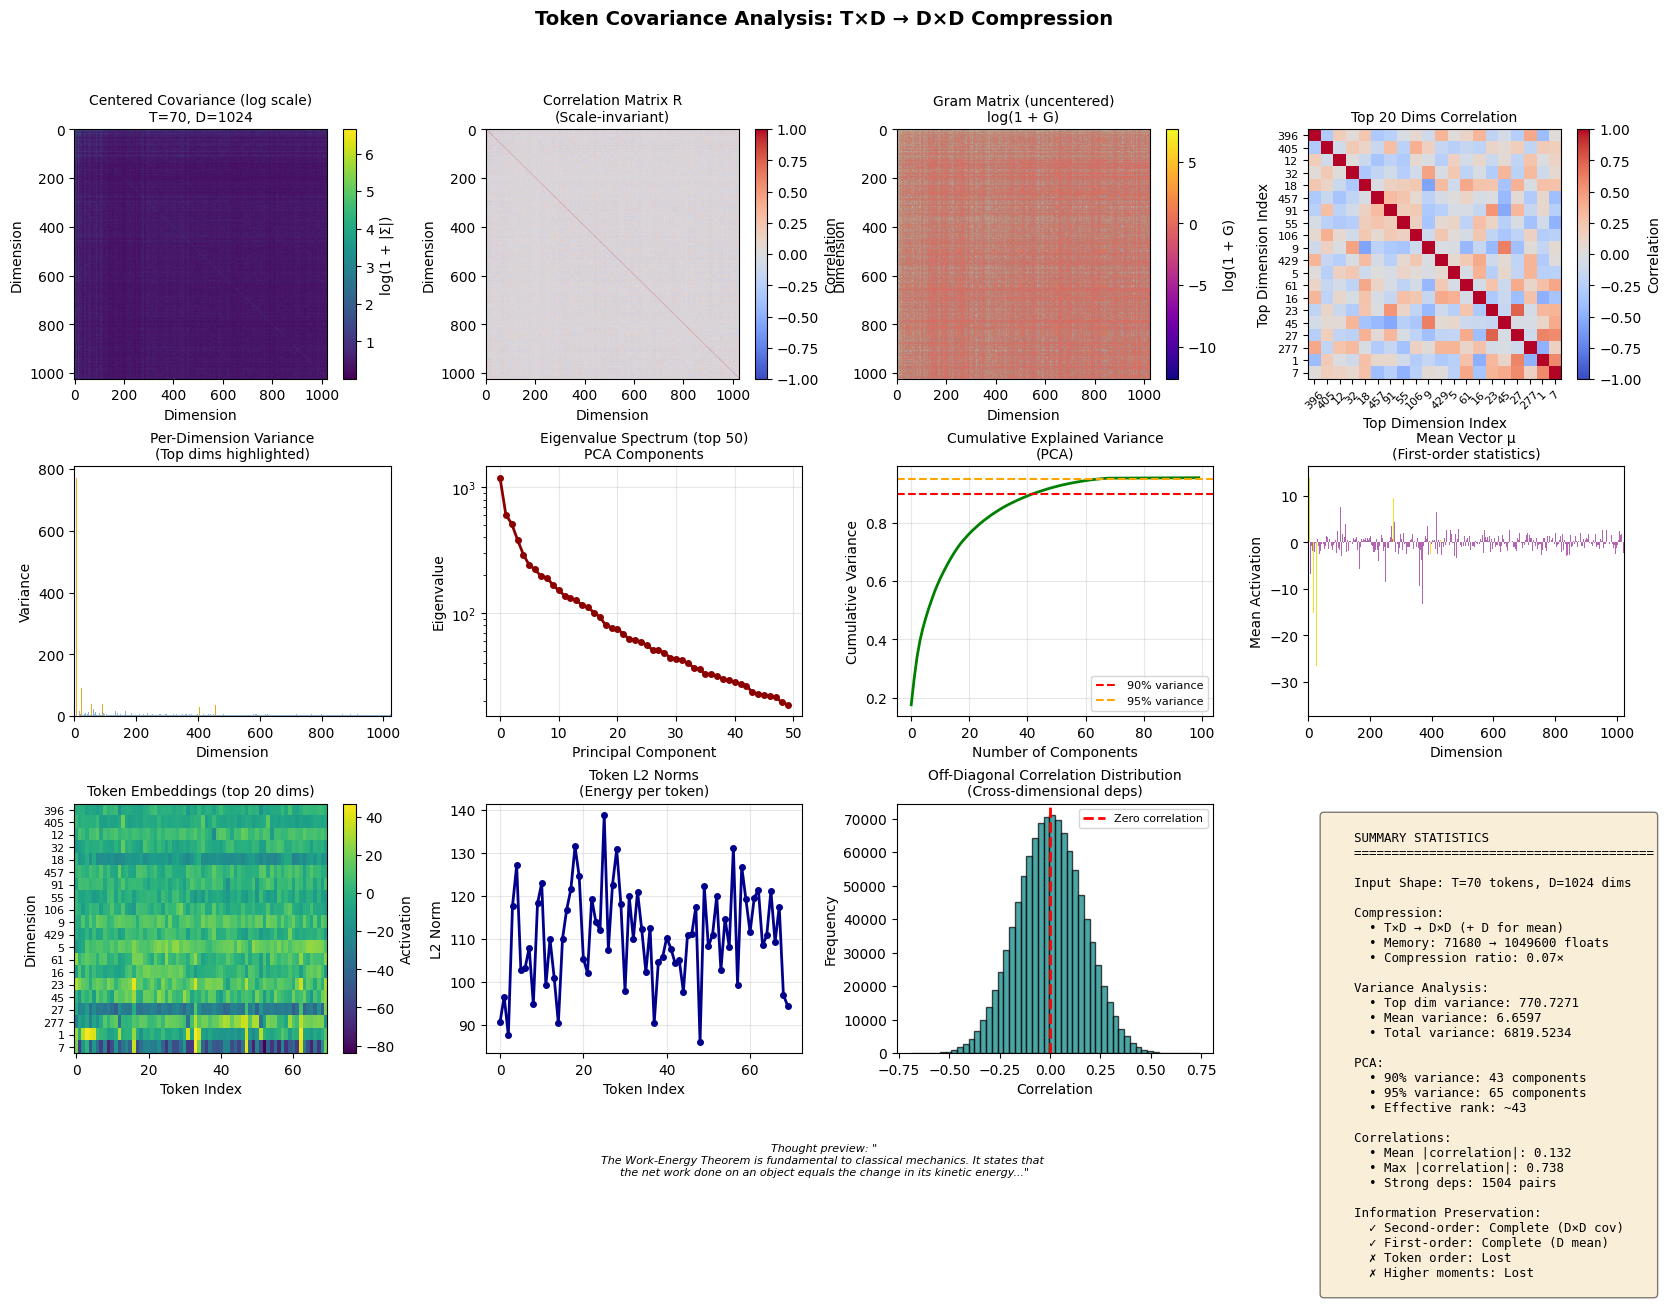


COVARIANCE COMPRESSION RESULTS
Input: 70 tokens × 1024 dimensions = 71680 values
Output: Σ[1024×1024] + μ[1024] = 1049600 values
Compression ratio: 0.07×

Top 20 dimensions by variance:
  1. Dim 7: variance=770.7271
  2. Dim 1: variance=314.7661
  3. Dim 277: variance=267.4602
  4. Dim 27: variance=155.1690
  5. Dim 45: variance=97.9432
  6. Dim 23: variance=92.4706
  7. Dim 16: variance=77.1346
  8. Dim 61: variance=69.2459
  9. Dim 5: variance=57.1459
  10. Dim 429: variance=45.5974
  11. Dim 9: variance=43.5255
  12. Dim 106: variance=42.8557
  13. Dim 55: variance=40.0489
  14. Dim 91: variance=37.9181
  15. Dim 457: variance=36.2622
  16. Dim 18: variance=34.8858
  17. Dim 32: variance=34.0887
  18. Dim 12: variance=33.7649
  19. Dim 405: variance=29.7267
  20. Dim 396: variance=28.3583

90% variance captured by 43 principal components
95% variance captured by 65 principal components


In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# ============================================================================
# Covariance-Based Token Compression for Thought Embeddings
# ============================================================================
# This compresses T×D token embeddings into a D×D covariance matrix,
# preserving second-order statistics (cross-dimensional correlations).
# ============================================================================

def compute_token_covariance(H, method="centered", shrinkage=0.0):
    """
    Compress token embeddings H [T, D] into a D×D summary matrix.
    
    Args:
        H: torch.Tensor [T, D] - token embeddings (T=seq_len, D=embed_dim)
        method: str - "centered" (covariance) or "uncentered" (Gram matrix)
        shrinkage: float - Ledoit-Wolf style shrinkage (0.0 = none, 0.05 = mild)
    
    Returns:
        Sigma: torch.Tensor [D, D] - covariance or Gram matrix
        mu: torch.Tensor [D] - mean (only for centered method)
    """
    H = H.float()  # ensure float32 for stability
    T, D = H.shape
    
    if method == "centered":
        # Centered covariance (recommended)
        mu = H.mean(dim=0, keepdim=True)  # [1, D]
        Hc = H - mu  # center
        Sigma = (Hc.T @ Hc) / max(1, T - 1)  # [D, D]
        
        # Apply shrinkage if requested
        if shrinkage > 0:
            trace = torch.trace(Sigma)
            alpha = trace / D  # average variance
            Sigma = (1 - shrinkage) * Sigma + shrinkage * alpha * torch.eye(D, device=Sigma.device)
        
        return Sigma, mu.squeeze(0)
    
    elif method == "uncentered":
        # Gram matrix (uncentered second moment)
        G = (H.T @ H) / T  # [D, D]
        return G, None
    
    else:
        raise ValueError(f"Unknown method: {method}")


def covariance_to_correlation(Sigma):
    """
    Convert covariance matrix to correlation matrix.
    R[i,j] = Sigma[i,j] / sqrt(Sigma[i,i] * Sigma[j,j])
    
    Args:
        Sigma: torch.Tensor [D, D] - covariance matrix
    
    Returns:
        R: torch.Tensor [D, D] - correlation matrix
    """
    D = torch.diag(Sigma)  # diagonal (variances)
    D_inv_sqrt = 1.0 / torch.sqrt(D + 1e-8)  # avoid division by zero
    R = Sigma * D_inv_sqrt.unsqueeze(1) * D_inv_sqrt.unsqueeze(0)
    return R


def visualize_covariance_analysis(H, thought_text="", num_top_dims=10):
    """
    Comprehensive visualization of token covariance analysis.
    
    Args:
        H: torch.Tensor [T, D] - token embeddings
        thought_text: str - original thought text for context
        num_top_dims: int - number of top dimensions to highlight
    """
    T, D = H.shape
    
    # Compute covariance and correlation
    Sigma, mu = compute_token_covariance(H, method="centered", shrinkage=0.05)
    R = covariance_to_correlation(Sigma)
    G, _ = compute_token_covariance(H, method="uncentered")
    
    # Move to numpy for plotting
    Sigma_np = Sigma.cpu().numpy()
    R_np = R.cpu().numpy()
    G_np = G.cpu().numpy()
    mu_np = mu.cpu().numpy()
    
    # Find top dimensions by variance
    var_per_dim = np.diag(Sigma_np)
    top_dims = np.argsort(var_per_dim)[-num_top_dims:]
    
    # Compute eigenvalues for PCA
    eigenvalues, eigenvectors = np.linalg.eigh(Sigma_np)
    eigenvalues = eigenvalues[::-1]  # descending order
    cumulative_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))
    gs = GridSpec(3, 4, figure=fig, hspace=0.35, wspace=0.3)
    
    # ========================================================================
    # Row 1: Covariance Matrices
    # ========================================================================
    
    # 1. Centered Covariance (full)
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(np.log1p(np.abs(Sigma_np)), cmap='viridis', aspect='auto')
    ax1.set_title(f'Centered Covariance (log scale)\nT={T}, D={D}', fontsize=10)
    ax1.set_xlabel('Dimension')
    ax1.set_ylabel('Dimension')
    plt.colorbar(im1, ax=ax1, label='log(1 + |Σ|)')
    
    # 2. Correlation Matrix
    ax2 = fig.add_subplot(gs[0, 1])
    im2 = ax2.imshow(R_np, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax2.set_title('Correlation Matrix R\n(Scale-invariant)', fontsize=10)
    ax2.set_xlabel('Dimension')
    ax2.set_ylabel('Dimension')
    plt.colorbar(im2, ax=ax2, label='Correlation')
    
    # 3. Gram Matrix (uncentered)
    ax3 = fig.add_subplot(gs[0, 2])
    im3 = ax3.imshow(np.log1p(G_np), cmap='plasma', aspect='auto')
    ax3.set_title('Gram Matrix (uncentered)\nlog(1 + G)', fontsize=10)
    ax3.set_xlabel('Dimension')
    ax3.set_ylabel('Dimension')
    plt.colorbar(im3, ax=ax3, label='log(1 + G)')
    
    # 4. Top dimensions zoom (correlation)
    ax4 = fig.add_subplot(gs[0, 3])
    R_top = R_np[np.ix_(top_dims, top_dims)]
    im4 = ax4.imshow(R_top, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    ax4.set_title(f'Top {num_top_dims} Dims Correlation', fontsize=10)
    ax4.set_xlabel('Top Dimension Index')
    ax4.set_ylabel('Top Dimension Index')
    ax4.set_xticks(range(num_top_dims))
    ax4.set_yticks(range(num_top_dims))
    ax4.set_xticklabels([str(d) for d in top_dims], rotation=45, fontsize=8)
    ax4.set_yticklabels([str(d) for d in top_dims], fontsize=8)
    plt.colorbar(im4, ax=ax4, label='Correlation')
    
    # ========================================================================
    # Row 2: Statistical Analysis
    # ========================================================================
    
    # 5. Per-dimension variance
    ax5 = fig.add_subplot(gs[1, 0])
    ax5.bar(range(D), var_per_dim, color='steelblue', alpha=0.6, width=1.0)
    ax5.bar(top_dims, var_per_dim[top_dims], color='orange', alpha=0.8, width=1.0)
    ax5.set_title('Per-Dimension Variance\n(Top dims highlighted)', fontsize=10)
    ax5.set_xlabel('Dimension')
    ax5.set_ylabel('Variance')
    ax5.set_xlim([0, D])
    
    # 6. Eigenvalue spectrum (PCA)
    ax6 = fig.add_subplot(gs[1, 1])
    ax6.plot(eigenvalues[:50], 'o-', linewidth=2, markersize=4, color='darkred')
    ax6.set_title('Eigenvalue Spectrum (top 50)\nPCA Components', fontsize=10)
    ax6.set_xlabel('Principal Component')
    ax6.set_ylabel('Eigenvalue')
    ax6.set_yscale('log')
    ax6.grid(True, alpha=0.3)
    
    # 7. Cumulative explained variance
    ax7 = fig.add_subplot(gs[1, 2])
    ax7.plot(cumulative_variance[:100], linewidth=2, color='green')
    ax7.axhline(0.9, color='red', linestyle='--', label='90% variance')
    ax7.axhline(0.95, color='orange', linestyle='--', label='95% variance')
    ax7.set_title('Cumulative Explained Variance\n(PCA)', fontsize=10)
    ax7.set_xlabel('Number of Components')
    ax7.set_ylabel('Cumulative Variance')
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3)
    
    # 8. Mean vector
    ax8 = fig.add_subplot(gs[1, 3])
    ax8.bar(range(D), mu_np, color='purple', alpha=0.6, width=1.0)
    ax8.bar(top_dims, mu_np[top_dims], color='yellow', alpha=0.8, width=1.0)
    ax8.set_title('Mean Vector μ\n(First-order statistics)', fontsize=10)
    ax8.set_xlabel('Dimension')
    ax8.set_ylabel('Mean Activation')
    ax8.set_xlim([0, D])
    
    # ========================================================================
    # Row 3: Token-level analysis
    # ========================================================================
    
    # 9. Original token embeddings (top dims)
    ax9 = fig.add_subplot(gs[2, 0])
    H_top = H[:, top_dims].cpu().numpy()
    im9 = ax9.imshow(H_top.T, aspect='auto', cmap='viridis')
    ax9.set_title(f'Token Embeddings (top {num_top_dims} dims)', fontsize=10)
    ax9.set_xlabel('Token Index')
    ax9.set_ylabel('Dimension')
    ax9.set_yticks(range(num_top_dims))
    ax9.set_yticklabels([str(d) for d in top_dims], fontsize=8)
    plt.colorbar(im9, ax=ax9, label='Activation')
    
    # 10. Token norms
    ax10 = fig.add_subplot(gs[2, 1])
    token_norms = torch.norm(H, dim=1).cpu().numpy()
    ax10.plot(token_norms, 'o-', linewidth=2, markersize=4, color='darkblue')
    ax10.set_title('Token L2 Norms\n(Energy per token)', fontsize=10)
    ax10.set_xlabel('Token Index')
    ax10.set_ylabel('L2 Norm')
    ax10.grid(True, alpha=0.3)
    
    # 11. Off-diagonal correlation strength
    ax11 = fig.add_subplot(gs[2, 2])
    # Mask diagonal and compute stats
    mask = ~np.eye(D, dtype=bool)
    off_diag_corr = R_np[mask]
    ax11.hist(off_diag_corr, bins=50, color='teal', alpha=0.7, edgecolor='black')
    ax11.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero correlation')
    ax11.set_title('Off-Diagonal Correlation Distribution\n(Cross-dimensional deps)', fontsize=10)
    ax11.set_xlabel('Correlation')
    ax11.set_ylabel('Frequency')
    ax11.legend(fontsize=8)
    
    # 12. Summary statistics
    ax12 = fig.add_subplot(gs[2, 3])
    ax12.axis('off')
    
    # Compute summary stats
    num_components_90 = np.searchsorted(cumulative_variance, 0.90) + 1
    num_components_95 = np.searchsorted(cumulative_variance, 0.95) + 1
    mean_corr = np.mean(np.abs(off_diag_corr))
    max_corr = np.max(np.abs(off_diag_corr))
    
    summary_text = f"""
    SUMMARY STATISTICS
    {'='*40}
    
    Input Shape: T={T} tokens, D={D} dims
    
    Compression:
      • T×D → D×D (+ D for mean)
      • Memory: {T*D} → {D*D + D} floats
      • Compression ratio: {T*D / (D*D + D):.2f}×
    
    Variance Analysis:
      • Top dim variance: {var_per_dim[top_dims[-1]]:.4f}
      • Mean variance: {np.mean(var_per_dim):.4f}
      • Total variance: {np.sum(var_per_dim):.4f}
    
    PCA:
      • 90% variance: {num_components_90} components
      • 95% variance: {num_components_95} components
      • Effective rank: ~{num_components_90}
    
    Correlations:
      • Mean |correlation|: {mean_corr:.3f}
      • Max |correlation|: {max_corr:.3f}
      • Strong deps: {np.sum(np.abs(off_diag_corr) > 0.5)} pairs
    
    Information Preservation:
      ✓ Second-order: Complete (D×D cov)
      ✓ First-order: Complete (D mean)
      ✗ Token order: Lost
      ✗ Higher moments: Lost
    """
    
    ax12.text(0.05, 0.95, summary_text, transform=ax12.transAxes,
             fontsize=9, verticalalignment='top', family='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Main title
    fig.suptitle('Token Covariance Analysis: T×D → D×D Compression', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    # Add thought preview if provided
    if thought_text:
        preview = thought_text[:150] + "..." if len(thought_text) > 150 else thought_text
        fig.text(0.5, 0.01, f'Thought preview: "{preview}"', 
                ha='center', fontsize=8, style='italic', wrap=True)
    
    plt.show()
    
    # Print numerical summary
    print("\n" + "="*70)
    print("COVARIANCE COMPRESSION RESULTS")
    print("="*70)
    print(f"Input: {T} tokens × {D} dimensions = {T*D} values")
    print(f"Output: Σ[{D}×{D}] + μ[{D}] = {D*D + D} values")
    print(f"Compression ratio: {T*D / (D*D + D):.2f}×")
    print(f"\nTop {num_top_dims} dimensions by variance:")
    for i, dim in enumerate(top_dims[::-1], 1):
        print(f"  {i}. Dim {dim}: variance={var_per_dim[dim]:.4f}")
    print(f"\n90% variance captured by {num_components_90} principal components")
    print(f"95% variance captured by {num_components_95} principal components")
    print("="*70)
    
    return Sigma, mu, R


# ============================================================================
# DEMO: Apply to thought embeddings
# ============================================================================

# Load model and get hidden states
model_name = "Qwen/Qwen3-0.6B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto"
)

# Example thought
thought = """
The Work-Energy Theorem is fundamental to classical mechanics. It states that 
the net work done on an object equals the change in its kinetic energy. This 
principle allows us to solve complex dynamics problems by focusing on energy 
rather than forces. The theorem is derived from Newton's second law through 
integration along the path of motion.
"""

# Get hidden states from last layer
model.eval()
with torch.no_grad():
    inputs = tokenizer(thought, return_tensors="pt", truncation=True).to(model.device)
    outputs = model(**inputs, output_hidden_states=True)
    H = outputs.hidden_states[-1].squeeze(0).to(torch.float32).cpu()

# Run comprehensive analysis
print(f"\nAnalyzing thought with {H.shape[0]} tokens in {H.shape[1]}-dimensional space...")
Sigma, mu, R = visualize_covariance_analysis(H, thought_text=thought, num_top_dims=20)


In [19]:
import torch
import numpy as np
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModel


def add_gumbel_noise(logits, temperature):
    if temperature == 0:
        return logits
    logits = logits.to(torch.float64)
    noise = torch.rand_like(logits, dtype=torch.float64)
    gumbel_noise = (- torch.log(noise)) ** temperature
    return logits.exp() / gumbel_noise


def get_num_transfer_tokens(mask_index, steps):
    mask_num = mask_index.sum(dim=1, keepdim=True)

    base = mask_num // steps
    remainder = mask_num % steps

    num_transfer_tokens = torch.zeros(mask_num.size(0), steps, device=mask_index.device, dtype=torch.int64) + base

    for i in range(mask_num.size(0)):
        num_transfer_tokens[i, :remainder[i]] += 1

    return num_transfer_tokens


@ torch.no_grad()
def generate(model, prompt, steps=128, gen_length=128, block_length=128, temperature=0.,
             cfg_scale=0., remasking='low_confidence', mask_id=156895):
    x = torch.full((1, prompt.shape[1] + gen_length), mask_id, dtype=torch.long).to(model.device)
    x[:, :prompt.shape[1]] = prompt.clone()
    prompt_index = (x != mask_id)

    assert gen_length % block_length == 0
    num_blocks = gen_length // block_length
    assert steps % num_blocks == 0
    steps = steps // num_blocks

    for num_block in range(num_blocks):
        block_mask_index = (x[:, prompt.shape[1] + num_block * block_length: prompt.shape[1] + (num_block + 1) * block_length:] == mask_id)
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)
        for i in range(steps):
            mask_index = (x == mask_id)
            if cfg_scale > 0.:
                un_x = x.clone()
                un_x[prompt_index] = mask_id
                x_ = torch.cat([x, un_x], dim=0)
                logits = model(x_).logits
                logits, un_logits = torch.chunk(logits, 2, dim=0)
                logits = un_logits + (cfg_scale + 1) * (logits - un_logits)
            else:
                logits = model(x).logits

            logits_with_noise = add_gumbel_noise(logits, temperature=temperature)
            x0 = torch.argmax(logits_with_noise, dim=-1) # b, l

            if remasking == 'low_confidence':
                p = F.softmax(logits, dim=-1)
                x0_p = torch.squeeze(
                    torch.gather(p, dim=-1, index=torch.unsqueeze(x0, -1)), -1) # b, l
            elif remasking == 'random':
                x0_p = torch.rand((x0.shape[0], x0.shape[1]), device=x0.device)
            else:
                raise NotImplementedError(remasking)

            x0_p[:, prompt.shape[1] + (num_block + 1) * block_length:] = -np.inf

            x0 = torch.where(mask_index, x0, x)
            confidence = torch.where(mask_index, x0_p, -np.inf)

            transfer_index = torch.zeros_like(x0, dtype=torch.bool, device=x0.device)
            for j in range(confidence.shape[0]):
                _, select_index = torch.topk(confidence[j], k=num_transfer_tokens[j, i])
                transfer_index[j, select_index] = True
            x[transfer_index] = x0[transfer_index]

    return x


device = 'cpu'
model = AutoModel.from_pretrained('inclusionAI/LLaDA-MoE-7B-A1B-Instruct', trust_remote_code=True, torch_dtype=torch.bfloat16).to(device).eval()
tokenizer = AutoTokenizer.from_pretrained('inclusionAI/LLaDA-MoE-7B-A1B-Instruct', trust_remote_code=True)

prompt = "Lily can run 12 kilometers per hour for 4 hours. After that, she runs 6 kilometers per hour. How many kilometers can she run in 8 hours?"
m = [
    {"role": "system", "content": "You are a helpful AI assistant."},
    {"role": "user", "content": prompt}
]
prompt = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
print(prompt)
input_ids = tokenizer(prompt)['input_ids']
input_ids = torch.tensor(input_ids).to(device).unsqueeze(0)

text = generate(model, input_ids, steps=128, gen_length=128, block_length=32, temperature=0., cfg_scale=0., remasking='low_confidence')
print(tokenizer.batch_decode(text[:, input_ids.shape[1]:], skip_special_tokens=False)[0])


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

<role>SYSTEM</role>You are a helpful AI assistant.
detailed thinking off<|role_end|><role>HUMAN</role>Lily can run 12 kilometers per hour for 4 hours. After that, she runs 6 kilometers per hour. How many kilometers can she run in 8 hours?<|role_end|><role>ASSISTANT</role>
Lily can run 12 kilometers per hour for 4 hours, so she can run 12 * 4 = 48 kilometers in the first 4 hours.
After that, she runs 6 kilometers per hour, so she can run 6 * 4 = 24 kilometers in the next 4 hours.
Therefore, Lily can run a total of 48 + 24 = 72 kilometers in 8 hours.
The answer is: 72<|role_end|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>
